## MEWpy GECKO Example

A GECKO model simulation and optimization example.

We start by loading the GECKO model for yeast.
The model may be loaded using the original implementation over COBRApy. 

In [1]:
# Using geckopy package.
from geckopy.gecko import GeckoModel
model = GeckoModel('single-pool')

The Simulation class enables to easily perform simulations considering specific environmental conditions as well as other constraint, such protein knockouts or over/under expression. 
 

In [2]:
# Define environmental conditions (limit glucose consumption) 
envcond = {'r_1714_REV':(-10,1000)}

from mewpy.simulation import get_simulator
simul = get_simulator(model,envcond= envcond)

We may list the proteins included in the model:

In [3]:
# simul.proteins

In [4]:
simul.find_proteins()

,reactions
Protein,
Q06708,"[r_3216No1, r_3217No1, r_3218No1, r_3219No1, r..."
P0CX11,"[r_0366No1, r_0366_REVNo1]"
P00127,[r_0439No1]
P18562,[r_1074No1]
P13259,[r_0274No1]
...,...
P40581,"[r_0483No5, r_0483_REVNo5]"
Q07729,[r_0526No1]
P06700,[r_0767No1]


We start by running a Flux Balance Analysis phenotype prediction.

In [5]:
# FBA
result =simul.simulate()
print(result)

objective: 0.3254251019507341
Status: OPTIMAL
Constraints: OrderedDict([('r_1714_REV', (-10, 1000))])
Method:SimulationMethod.FBA


We may check for individual protein usage (mmol/gDW):

In [6]:
result.find('P52867')

,Flux rate
Reaction ID,
draw_prot_P52867,6.576609e-07


or identify the kcat (1/h) of the protein for each associated reaction:

In [7]:
simul.get_Kcats('A2P2R3')

{'r_0477No1': 127800.4268534257}

Other phenotype simulation methods can explicitly be defined, such as parsimonious FBA.

In [8]:
result= simul.simulate(method='pFBA')
print(result)

objective: 743.6947396259584
Status: OPTIMAL
Constraints: OrderedDict([('r_1714_REV', (-10, 1000))])
Method:pFBA


We aim to later optimize the production of succinate, whose exchange reaction has the 'r_2056' identifier.
As such it is important to analyse the flux variability. By default, MEWpy considers a 90% fraction of the objective when running a FVA.

In [9]:
simul.FVA(reactions=['r_2056'])

{'r_2056': [0.0, 2.359164479620666]}

We might also look at flux's values on the wild type, using the results from the previous pFBA. The biomass reaction has the identifier 'r_2111'.

In [10]:
result.find(['r_2111','r_2056'])

,Flux rate
Reaction ID,
r_2056,0.000000
r_2111,0.325425
r_2056_REV,0.000000
r_2111_REV,0.000000


In the wild type, and without adding any condition, the model does not produce L-tyronine.

GECKO models integrate proteomics into GSMMs. As such we may be interested on identifying essential proteins.

In [11]:
essential = simul.essential_proteins()
essential[:10]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [01:54<00:00,  7.10it/s]


['P38707',
 'P06168',
 'P38998',
 'P06197',
 'P26637',
 'P08465',
 'Q04728',
 'Q05506',
 'P13188',
 'Q12122']

MEWpy allows to easily add contraints on proteins usage.

Let us consider a set of enzyme constraints obtained from a MEWpy optimization on the yeast GECKO model targeting the production of the same compound.

In [54]:
# Adding constraints to phenotype simulations
constraints = {'draw_prot_P13188': (0.0, 9.3e-07),
               'draw_prot_P39006': 0.0,
               'draw_prot_P08067': (0.0, 2.7e-07),
               'draw_prot_P38791': (0.0, 10000)}

We may now add these new constraints to a pFBA prediction, and analyse the L-tyrosine production and biomass.

In [55]:
result = simul.simulate(constraints=constraints, method='pFBA')
result.find(['r_2111','r_2056'])

,Flux rate
Reaction ID,
r_2056,0.026167
r_2111,0.081432
r_2056_REV,0.000000
r_2111_REV,0.000000


We can observe that the simulation predicts that the introduce modifications will allow the organism to produce L-tyrosine.
Let us now perfom a flux balance analysis accounting with the modifications as well as plot the production envelope.

In [56]:
simul.FVA('r_2056',constraints=constraints)

{'r_2056': [0.0, 13.940164516803268]}

<AxesSubplot:xlabel='r_2111', ylabel='r_2056'>

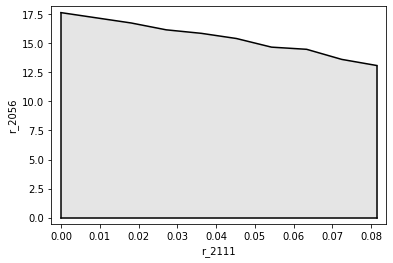

In [57]:
from mewpy.visualization.envelope import plot_flux_envelope
plot_flux_envelope(simul,'r_2111','r_2056',constraints=constraints)

## GECKO model Optimization

We will now optimize the production of L-tyrosine by modifying the GECKO model enzymatic contraints, that is, by altering the availability of enzymes.

The optimization is performed by defining an Evolutionary Algorithm Optimization Problem.
To define a problem we start by identifiying the objective functions: biomass-product coupled yield and weighted yield.

In [16]:
from mewpy.optimization.evaluation import BPCY, WYIELD

evaluator_1 = BPCY("r_2111", "r_2056", method='lMOMA') 
evaluator_2 = WYIELD("r_2111", "r_2056")


We aim to find solutions that only include protein deletions or knock out, as such, we will instatiate a GeckoKOProblem, and consider a maximum of 6 deletions. 

In [17]:
# creates a new optimization problem
from mewpy.problems import GeckoOUProblem

problem = GeckoOUProblem(model, 
                          fevaluation=[evaluator_1,evaluator_2], 
                          envcond = envcond,
                          candidate_max_size = 6)

We may now start the optimization process by instantiating an EA for the problem and set the running preferences.

In [18]:
from mewpy.optimization import EA
import warnings
warnings.filterwarnings("ignore")

ea = EA(problem, max_generations = 10)

# runs the optimization
final_pop = ea.run(simplify=False)


Running NSGAII
Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  0.000000  0.010708  0.000000  0.000121  0.001073|  0.000000  4.067287  0.102922  0.253239  0.762105|
    200|  -0.000000  0.010708  0.000000  0.000695  0.002545|  0.102922  4.067287  0.102922  0.388153  0.937294|
    300|  -0.000000  0.010708  0.000000  0.001740  0.003816|  0.102922  4.067287  0.103603  0.872111  1.434302|
    400|  -0.000000  0.010709  0.001366  0.004155  0.004978|  0.107199  4.690901  2.792979  2.013231  1.732872|
    500|  0.000000  0.010709  0.010657  0.007674  0.004347|  0.133526  4.690902  0.155872  1.357455  1.814215|
    600|  0.000000  0.043608  0.010631  0.008231  0.005477|  0.133526  4.690902  0.166854  1.255238  1.766611|
    700|  0.000000  0.043608  0.010618  0.008442  0.006335|  0.133833  4.690902  0.172346  1.458165  1.798126|
    800|  0.000000  0.043608  0.010618  0.007737  0.007425|  0.133833  4.690902  2.697318  2.0

The final population contains the best solutions found by the EA. We may choose to save the solutions, or run some analysis as previously seen.

In [19]:
df = ea.dataframe()
df

,Modification,Size,BPCY,WYIELD
0,"{'draw_prot_P53630': 0.125, 'draw_prot_P25578'...",5,0.043608,0.154928
1,"{'draw_prot_P38139': 0.03125, 'draw_prot_P5407...",6,0.005464,2.795347
2,"{'draw_prot_P32377': 0.125, 'draw_prot_P0CX10'...",6,0.000000,4.692105
3,"{'draw_prot_P39006': 0.125, 'draw_prot_P08067'...",5,0.000342,4.690901
4,"{'draw_prot_P39006': 0.125, 'draw_prot_P08067'...",6,0.013899,2.795297
...,...,...,...,...
91,"{'draw_prot_P38139': 0.03125, 'draw_prot_P3228...",4,0.005464,2.792979
92,"{'draw_prot_P39006': 0.125, 'draw_prot_P38791'...",6,0.002121,4.067287
93,"{'draw_prot_P13188': 0.25, 'draw_prot_P39006':...",4,0.002121,4.067285
94,"{'draw_prot_P13188': 0.25, 'draw_prot_P39006':...",5,0.002121,4.067286


In [20]:
solution = df['Modification'][1]

In [42]:
problem.simulate(solution=solution,method='pFBA').find(["r_2111", "r_2056"])

,Flux rate
Reaction ID,
r_2056,0.033581
r_2111,0.162713
r_2056_REV,0.000000
r_2111_REV,0.000000
